In [2]:
import numpy as np  # linear algebra
import pandas as pd  #
from datetime import datetime

from scipy.stats import skew  # for some statistics
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

# from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
# from sklearn.ensemble import GradientBoostingRegressor
# from sklearn.svm import SVR
# from sklearn.pipeline import make_pipeline
# from sklearn.preprocessing import RobustScaler
# from sklearn.model_selection import KFold, cross_val_score
# from sklearn.metrics import mean_squared_error

# from mlxtend.regressor import StackingCVRegressor

# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor

import os

import matplotlib.pyplot as plt

print(os.listdir("home_data"))

['test.csv.gz', 'sample_submission.csv.gz', 'test.csv', 'data_description.txt', 'train.csv', 'train.csv.gz', 'sample_submission.csv']


In [3]:
pd.set_option('display.max_columns', 500)

In [4]:
'''read in top result for test data'''
top_submission_saleprice = pd.read_csv('SalePrice_top_submission.csv')
top_submission_saleprice

,id,SalePrice
0,1461,121390.504435
1,1462,161597.008073
2,1463,181572.678008
3,1464,198661.910814
4,1465,198232.723419
...,...,...
1454,2915,85625.364846
1455,2916,75548.930331
1456,2917,165094.155007
1457,2918,121992.985154


In [5]:
train = pd.read_csv('home_data/train.csv')
test = pd.read_csv('home_data/test.csv')
print("Train set size:", train.shape)
print("Test set size:", test.shape)
print('START data processing', datetime.now(), )

Train set size: (1460, 81)
Test set size: (1459, 80)
START data processing 2022-04-19 20:05:55.497395


In [6]:
'''recover sale price for test data using online top result'''
test['SalePrice'] = top_submission_saleprice.SalePrice
test

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,121390.504435
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,161597.008073
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,181572.678008
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal,198661.910814
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal,198232.723419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,Twnhs,2Story,4,7,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Unf,0.0,Unf,0.0,546.0,546.0,GasA,Gd,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,5,Typ,0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal,85625.364846
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,MeadowV,Norm,Norm,TwnhsE,2Story,4,5,1970,1970,Gable,CompShg,CemntBd,CmentBd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,252.0,Unf,0.0,294.0,546.0,GasA,TA,Y,SBrkr,546,546,0,1092,0.0,0.0,1,1,3,1,TA,6,Typ,0,NaN,CarPort,1970.0,Unf,1.0,286.0,TA,TA,Y,0,24,0,0,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,75548.930331
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1Story,5,7,1960,1996,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,ALQ,1224.0,Unf,0.0,0.0,1224.0,GasA,Ex,Y,SBrkr,1224,0,0,1224,1.0,0.0,1,0,4,1,TA,7,Typ,1,TA,Detchd,1960.0,Unf,2.0,576.0,TA,TA,Y,474,0,0,0,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,165094

In [7]:
'''Concat train and join (I just want to get a whole dataset'''
train = pd.concat([train, test])
train.shape

(2919, 81)

In [8]:
train_ID = train['Id']
test_ID = test['Id']

# Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop(['Id'], axis=1, inplace=True)
test.drop(['Id'], axis=1, inplace=True)

In [9]:
# Deleting outliers
train = train[train.GrLivArea < 4500]
train.reset_index(drop=True, inplace=True)


In [10]:
'''copy the original sale price for later categorization'''
sale_price = train['SalePrice'].copy()

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])
y = train.SalePrice.reset_index(drop=True)
train_features = train.drop(['SalePrice'], axis=1)
test_features = test


In [11]:
'''gnerate category sale price as new targete'''
# '''Update: use int for categories'''
sale_price.describe()

y_cat = pd.cut(
    x=sale_price,
    bins=[0, 130000, 165000, 214000, np.inf],
    labels=["low", "mid", "mid-hi", "hi"],
    # labels=[0, 1, 2, 3],
)

y_cat.value_counts()

mid       771
low       766
hi        709
mid-hi    670
Name: SalePrice, dtype: int64

In [12]:
features = pd.concat([train_features, test_features]).reset_index(drop=True)
print(features.shape)

(4375, 80)


In [13]:
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])

features["PoolQC"] = features["PoolQC"].fillna("None")

In [14]:
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [15]:
# Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

In [16]:
skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])


/Users/evantilu/miniforge3/envs/6998_DL_tf/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4068: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/Users/evantilu/miniforge3/envs/6998_DL_tf/lib/python3.8/site-packages/scipy/stats/_stats_py.py:4098: PearsonRNearConstantInputWarning: An input array is nearly constant; the computed correlation coefficient may be inaccurate.
  warnings.warn(PearsonRNearConstantInputWarning())


In [17]:
# simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)


In [18]:
print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)


(4375, 87)
(4375, 334)


In [19]:
X = final_features.iloc[:len(y), :]
X_sub = final_features.iloc[len(X):, :]

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (2916, 334) y (2916,) X_sub (1459, 334)


In [20]:
outliers = [30, 88, 462, 631, 1322]
X = X.drop(X.index[outliers])
y = y.drop(y.index[outliers])


In [21]:
overfit = []
for i in X.columns:
    counts = X[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X = X.drop(overfit, axis=1).copy()
X_sub = X_sub.drop(overfit, axis=1).copy()

print('X', X.shape, 'y', y.shape, 'X_sub', X_sub.shape)

X (2911, 321) y (2911,) X_sub (1459, 321)


In [22]:
'''
Find the least correlated feature, dopr it (so will have 330 features that can make into 15*22 "images")
Update: if add in test data than it becomes 320 after dropping this one feature
Update 2: Don't drop this feature, since we are going to pad to 324 features to make 18*18 square images for easier CNN training
    but do drop the sales column before we do the sacling
'''

# join back sales price (target)
X['SalePrice'] = y

corr = X.corr()
corr.sort_values(['SalePrice'], ascending=False, inplace=True)

# print the correlation to SalePrice
# corr['SalePrice']

# sort columns by correlation
order = corr.index
X = X.loc[:, order]


# turned out the MoSold_10 is the least correlated feature
# X.drop(['MoSold_10'], axis=1, inplace=True)

# remember to drop the target as well
X.drop(['SalePrice'], axis=1, inplace=True)

X

,OverallQual,GrLivArea,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,TotalSF,Foundation_PConc,TotRmsAbvGrd,hasfireplace,ExterQual_Gd,Fireplaces,BsmtQual_Ex,HeatingQC_Ex,MasVnrArea,Total_porch_sf,BsmtFinType1_GLQ,KitchenQual_Ex,OpenPorchSF,GarageFinish_Fin,GarageType_Attchd,MSSubClass_60,KitchenQual_Gd,LotArea,ExterQual_Ex,Neighborhood_NridgHt,BsmtFinSF1,Exterior1st_VinylSd,WoodDeckSF,FireplaceQu_Gd,Exterior2nd_VinylSd,CentralAir_Y,LotFrontage,GarageCond_TA,Total_sqr_footage,PavedDrive_Y,GarageQual_TA,GarageYrBlt,SaleType_New,SaleCondition_Partial,BsmtQual_Gd,HalfBath,hasgarage,BsmtExposure_Gd,LotShape_IR1,Electrical_SBrkr,MSZoning_RL,MasVnrType_Stone,2ndFlrSF,BsmtFullBath,MasVnrType_BrkFace,Neighborhood_NoRidge,HouseStyle_2Story,RoofStyle_Hip,GarageFinish_RFn,GarageType_BuiltIn,hasbsmt,FireplaceQu_Ex,BsmtUnfSF,Neighborhood_StoneBr,FireplaceQu_TA,BedroomAbvGr,Neighborhood_Somerst,Fence_None,LandContour_HLS,LotConfig_CulDSac,BsmtCond_TA,BsmtExposure_Av,MSZoning_FV,Neighborhood_Timber,Functional_Typ,Neighborhood_CollgCr,Alley_None,BsmtFinType2_Unf,ExterCond_TA,Condition1_Norm,has2ndfloor,MSSubClass_120,LotShape_IR2,BldgType_1Fam,Heating_GasA,ScreenPorch,Exterior1st_CemntBd,BsmtCond_Gd,Exterior2nd_CmentBd,Neighborhood_Veenker,Neighborhood_Crawfor,RoofMatl_WdShngl,Condition1_PosN,Condition2_PosA,Neighborhood_Gilbert,MSSubClass_20,GarageQual_Gd,haspool,Condition2_PosN,MiscFeature_None,Neighborhood_NWAmes,Neighborhood_ClearCr,PoolArea,Condition1_PosA,RoofMatl_WdShake,BldgType_TwnhsE,Exterior2nd_ImStucc,BsmtExposure_Mn,3SsnPorch,LandSlope_Mod,LotShape_IR3,Neighborhood_SawyerW,YrSold_2007,ExterCond_Ex,Neighborhood_Blmngtn,BsmtFinType2_GLQ,Exterior1st_Stone,Exterior2nd_BrkFace,Exterior1st_BrkFace,LandContour_Low,HouseStyle_2.5Fin,Condition1_RRNn,LandSlope_Sev,MoSold_8,Alley_Pave,SaleType_Con,Condition1_RRAn,MoSold_7,SaleType_CWD,LotConfig_FR3,MoSold_9,MoSold_11,GarageCond_Gd,MoSold_1,BsmtFinType2_ALQ,MSSubClass_75,GarageQual_Ex,RoofStyle_Shed,MoSold_12,MoSold_6,RoofStyle_Flat,RoofMatl_Tar&Grv,YrSold_2009,MoSold_2,Fence_GdPrv,Foundation_Wood,HouseStyle_2.5Unf,LotConfig_Corner,LotConfig_FR2,YrSold_2006,MoSold_10,YrSold_2008,SaleType_ConLI,MSSubClass_80,Condition2_Norm,RoofStyle_Mansard,FireplaceQu_Fa,MiscFeature_Gar2,HouseStyle_SLvl,Exterior1st_Plywood,GarageType_2Types,Heating_OthW,BsmtFinSF2,Exterior2nd_Stone,GarageCond_Ex,MoSold_5,MoSold_3,MSSubClass_40,SaleCondition_Alloca,MiscFeature_Othr,Heating_GasW,Condition1_RRNe,Foundation_Stone,Exterior1st_CBlock,Functional_Maj1,Exterior2nd_AsphShn,BsmtFinType2_LwQ,BsmtHalfBath,Condition2_Feedr,BsmtFinType2_BLQ,SaleCondition_Family,Exterior2nd_CBlock,BsmtFinType2_Rec,Exterior1st_AsphShn,Condition2_Artery,Neighborhood_Mitchel,Exterior1st_BrkComm,Fence_MnWw,RoofStyle_Gambrel,Condition2_RRNn,Neighborhood_Blueste,Functional_Sev,Exterior2nd_Plywood,YrSold_2010,GarageType_Basment,SaleType_Oth,Neighborhood_NPkVill,MoSold_4,MSSubClass_85,LandSlope_Gtl,ExterCond_Po,MSSubClass_70,SaleType_ConLw,BsmtCond_Po,MasVnrType_BrkCmn,HouseStyle_1Story,ExterCond_Gd,LandContour_Lvl,Exterior2nd_Brk Cmn,MSZoning_RH,Condition1_RRAe,OverallCond,MiscVal,FireplaceQu_Po,Exterior1st_WdShing,LowQualFinSF,Functional_Min1,HeatingQC_Po,Functional_Mod,MiscFeature_Shed,GarageQual_Po,Exterior1st_Stucco,Exterior2nd_Stucco,BsmtFinType1_ALQ,RoofMatl_CompShg,Exterior2nd_Wd Shng,Functional_Min2,SaleType_ConLD,Heating_Wall,Neighborhood_SWISU,GarageType_CarPort,SaleCondition_AdjLand,MSSubClass_45,HouseStyle_SFoyer,Electrical_FuseP,Exterior2nd_HdBoard,LotConfig_Inside,HouseStyle_1.5Unf,MSSubClass_90,BldgType_Duplex,PavedDrive_P,BsmtFinType1_LwQ,MSSubClass_180,Functional_Maj2,Exterior1st_HdBoard,GarageCond_Po,SaleCondition_Normal,LandContour_Bnk,SaleType_COD,Fence_GdWo,Heating_Grav,MSSubClass_190,BldgType_2fmCon,KitchenAbvGr,BsmtFinType1_BLQ,BsmtFinType1_Unf,Neighborhood_BrDale,Condition1_Feedr,BldgType_Twnhs,MSSubClass_160,HeatingQC_Gd,Neighborhood_Sawyer,Condition1_Artery,Exterio

In [24]:
'''Scaling'''
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# scaler = RobustScaler()
# X_scaled = scaler.fit_transform(X)

'''standard scaler'''
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

'''Minmax scale to 0~1'''
minmax_scaler = MinMaxScaler(feature_range=(0, 1))
X_scaled = minmax_scaler.fit_transform(X)

# X_scaled.shape
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.describe()



,OverallQual,GrLivArea,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,TotalSF,Foundation_PConc,TotRmsAbvGrd,hasfireplace,ExterQual_Gd,Fireplaces,BsmtQual_Ex,HeatingQC_Ex,MasVnrArea,Total_porch_sf,BsmtFinType1_GLQ,KitchenQual_Ex,OpenPorchSF,GarageFinish_Fin,GarageType_Attchd,MSSubClass_60,KitchenQual_Gd,LotArea,ExterQual_Ex,Neighborhood_NridgHt,BsmtFinSF1,Exterior1st_VinylSd,WoodDeckSF,FireplaceQu_Gd,Exterior2nd_VinylSd,CentralAir_Y,LotFrontage,GarageCond_TA,Total_sqr_footage,PavedDrive_Y,GarageQual_TA,GarageYrBlt,SaleType_New,SaleCondition_Partial,BsmtQual_Gd,HalfBath,hasgarage,BsmtExposure_Gd,LotShape_IR1,Electrical_SBrkr,MSZoning_RL,MasVnrType_Stone,2ndFlrSF,BsmtFullBath,MasVnrType_BrkFace,Neighborhood_NoRidge,HouseStyle_2Story,RoofStyle_Hip,GarageFinish_RFn,GarageType_BuiltIn,hasbsmt,FireplaceQu_Ex,BsmtUnfSF,Neighborhood_StoneBr,FireplaceQu_TA,BedroomAbvGr,Neighborhood_Somerst,Fence_None,LandContour_HLS,LotConfig_CulDSac,BsmtCond_TA,BsmtExposure_Av,MSZoning_FV,Neighborhood_Timber,Functional_Typ,Neighborhood_CollgCr,Alley_None,BsmtFinType2_Unf,ExterCond_TA,Condition1_Norm,has2ndfloor,MSSubClass_120,LotShape_IR2,BldgType_1Fam,Heating_GasA,ScreenPorch,Exterior1st_CemntBd,BsmtCond_Gd,Exterior2nd_CmentBd,Neighborhood_Veenker,Neighborhood_Crawfor,RoofMatl_WdShngl,Condition1_PosN,Condition2_PosA,Neighborhood_Gilbert,MSSubClass_20,GarageQual_Gd,haspool,Condition2_PosN,MiscFeature_None,Neighborhood_NWAmes,Neighborhood_ClearCr,PoolArea,Condition1_PosA,RoofMatl_WdShake,BldgType_TwnhsE,Exterior2nd_ImStucc,BsmtExposure_Mn,3SsnPorch,LandSlope_Mod,LotShape_IR3,Neighborhood_SawyerW,YrSold_2007,ExterCond_Ex,Neighborhood_Blmngtn,BsmtFinType2_GLQ,Exterior1st_Stone,Exterior2nd_BrkFace,Exterior1st_BrkFace,LandContour_Low,HouseStyle_2.5Fin,Condition1_RRNn,LandSlope_Sev,MoSold_8,Alley_Pave,SaleType_Con,Condition1_RRAn,MoSold_7,SaleType_CWD,LotConfig_FR3,MoSold_9,MoSold_11,GarageCond_Gd,MoSold_1,BsmtFinType2_ALQ,MSSubClass_75,GarageQual_Ex,RoofStyle_Shed,MoSold_12,MoSold_6,RoofStyle_Flat,RoofMatl_Tar&Grv,YrSold_2009,MoSold_2,Fence_GdPrv,Foundation_Wood,HouseStyle_2.5Unf,LotConfig_Corner,LotConfig_FR2,YrSold_2006,MoSold_10,YrSold_2008,SaleType_ConLI,MSSubClass_80,Condition2_Norm,RoofStyle_Mansard,FireplaceQu_Fa,MiscFeature_Gar2,HouseStyle_SLvl,Exterior1st_Plywood,GarageType_2Types,Heating_OthW,BsmtFinSF2,Exterior2nd_Stone,GarageCond_Ex,MoSold_5,MoSold_3,MSSubClass_40,SaleCondition_Alloca,MiscFeature_Othr,Heating_GasW,Condition1_RRNe,Foundation_Stone,Exterior1st_CBlock,Functional_Maj1,Exterior2nd_AsphShn,BsmtFinType2_LwQ,BsmtHalfBath,Condition2_Feedr,BsmtFinType2_BLQ,SaleCondition_Family,Exterior2nd_CBlock,BsmtFinType2_Rec,Exterior1st_AsphShn,Condition2_Artery,Neighborhood_Mitchel,Exterior1st_BrkComm,Fence_MnWw,RoofStyle_Gambrel,Condition2_RRNn,Neighborhood_Blueste,Functional_Sev,Exterior2nd_Plywood,YrSold_2010,GarageType_Basment,SaleType_Oth,Neighborhood_NPkVill,MoSold_4,MSSubClass_85,LandSlope_Gtl,ExterCond_Po,MSSubClass_70,SaleType_ConLw,BsmtCond_Po,MasVnrType_BrkCmn,HouseStyle_1Story,ExterCond_Gd,LandContour_Lvl,Exterior2nd_Brk Cmn,MSZoning_RH,Condition1_RRAe,OverallCond,MiscVal,FireplaceQu_Po,Exterior1st_WdShing,LowQualFinSF,Functional_Min1,HeatingQC_Po,Functional_Mod,MiscFeature_Shed,GarageQual_Po,Exterior1st_Stucco,Exterior2nd_Stucco,BsmtFinType1_ALQ,RoofMatl_CompShg,Exterior2nd_Wd Shng,Functional_Min2,SaleType_ConLD,Heating_Wall,Neighborhood_SWISU,GarageType_CarPort,SaleCondition_AdjLand,MSSubClass_45,HouseStyle_SFoyer,Electrical_FuseP,Exterior2nd_HdBoard,LotConfig_Inside,HouseStyle_1.5Unf,MSSubClass_90,BldgType_Duplex,PavedDrive_P,BsmtFinType1_LwQ,MSSubClass_180,Functional_Maj2,Exterior1st_HdBoard,GarageCond_Po,SaleCondition_Normal,LandContour_Bnk,SaleType_COD,Fence_GdWo,Heating_Grav,MSSubClass_190,BldgType_2fmCon,KitchenAbvGr,BsmtFinType1_BLQ,BsmtFinType1_Unf,Neighborhood_BrDale,Condition1_Feedr,BldgType_Twnhs,MSSubClass_160,HeatingQC_Gd,Neighborhood_Sawyer,Condition1_Artery,Exterio

In [25]:
'''
add 3 dummny features to make it 18*18 for CNN
padding to make it a perfect square, 324
'''

X_scaled_df['dummy_1'] = 0.0
X_scaled_df['dummy_2'] = 0.0
X_scaled_df['dummy_3'] = 0.0
X_scaled_df

,OverallQual,GrLivArea,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,TotalSF,Foundation_PConc,TotRmsAbvGrd,hasfireplace,ExterQual_Gd,Fireplaces,BsmtQual_Ex,HeatingQC_Ex,MasVnrArea,Total_porch_sf,BsmtFinType1_GLQ,KitchenQual_Ex,OpenPorchSF,GarageFinish_Fin,GarageType_Attchd,MSSubClass_60,KitchenQual_Gd,LotArea,ExterQual_Ex,Neighborhood_NridgHt,BsmtFinSF1,Exterior1st_VinylSd,WoodDeckSF,FireplaceQu_Gd,Exterior2nd_VinylSd,CentralAir_Y,LotFrontage,GarageCond_TA,Total_sqr_footage,PavedDrive_Y,GarageQual_TA,GarageYrBlt,SaleType_New,SaleCondition_Partial,BsmtQual_Gd,HalfBath,hasgarage,BsmtExposure_Gd,LotShape_IR1,Electrical_SBrkr,MSZoning_RL,MasVnrType_Stone,2ndFlrSF,BsmtFullBath,MasVnrType_BrkFace,Neighborhood_NoRidge,HouseStyle_2Story,RoofStyle_Hip,GarageFinish_RFn,GarageType_BuiltIn,hasbsmt,FireplaceQu_Ex,BsmtUnfSF,Neighborhood_StoneBr,FireplaceQu_TA,BedroomAbvGr,Neighborhood_Somerst,Fence_None,LandContour_HLS,LotConfig_CulDSac,BsmtCond_TA,BsmtExposure_Av,MSZoning_FV,Neighborhood_Timber,Functional_Typ,Neighborhood_CollgCr,Alley_None,BsmtFinType2_Unf,ExterCond_TA,Condition1_Norm,has2ndfloor,MSSubClass_120,LotShape_IR2,BldgType_1Fam,Heating_GasA,ScreenPorch,Exterior1st_CemntBd,BsmtCond_Gd,Exterior2nd_CmentBd,Neighborhood_Veenker,Neighborhood_Crawfor,RoofMatl_WdShngl,Condition1_PosN,Condition2_PosA,Neighborhood_Gilbert,MSSubClass_20,GarageQual_Gd,haspool,Condition2_PosN,MiscFeature_None,Neighborhood_NWAmes,Neighborhood_ClearCr,PoolArea,Condition1_PosA,RoofMatl_WdShake,BldgType_TwnhsE,Exterior2nd_ImStucc,BsmtExposure_Mn,3SsnPorch,LandSlope_Mod,LotShape_IR3,Neighborhood_SawyerW,YrSold_2007,ExterCond_Ex,Neighborhood_Blmngtn,BsmtFinType2_GLQ,Exterior1st_Stone,Exterior2nd_BrkFace,Exterior1st_BrkFace,LandContour_Low,HouseStyle_2.5Fin,Condition1_RRNn,LandSlope_Sev,MoSold_8,Alley_Pave,SaleType_Con,Condition1_RRAn,MoSold_7,SaleType_CWD,LotConfig_FR3,MoSold_9,MoSold_11,GarageCond_Gd,MoSold_1,BsmtFinType2_ALQ,MSSubClass_75,GarageQual_Ex,RoofStyle_Shed,MoSold_12,MoSold_6,RoofStyle_Flat,RoofMatl_Tar&Grv,YrSold_2009,MoSold_2,Fence_GdPrv,Foundation_Wood,HouseStyle_2.5Unf,LotConfig_Corner,LotConfig_FR2,YrSold_2006,MoSold_10,YrSold_2008,SaleType_ConLI,MSSubClass_80,Condition2_Norm,RoofStyle_Mansard,FireplaceQu_Fa,MiscFeature_Gar2,HouseStyle_SLvl,Exterior1st_Plywood,GarageType_2Types,Heating_OthW,BsmtFinSF2,Exterior2nd_Stone,GarageCond_Ex,MoSold_5,MoSold_3,MSSubClass_40,SaleCondition_Alloca,MiscFeature_Othr,Heating_GasW,Condition1_RRNe,Foundation_Stone,Exterior1st_CBlock,Functional_Maj1,Exterior2nd_AsphShn,BsmtFinType2_LwQ,BsmtHalfBath,Condition2_Feedr,BsmtFinType2_BLQ,SaleCondition_Family,Exterior2nd_CBlock,BsmtFinType2_Rec,Exterior1st_AsphShn,Condition2_Artery,Neighborhood_Mitchel,Exterior1st_BrkComm,Fence_MnWw,RoofStyle_Gambrel,Condition2_RRNn,Neighborhood_Blueste,Functional_Sev,Exterior2nd_Plywood,YrSold_2010,GarageType_Basment,SaleType_Oth,Neighborhood_NPkVill,MoSold_4,MSSubClass_85,LandSlope_Gtl,ExterCond_Po,MSSubClass_70,SaleType_ConLw,BsmtCond_Po,MasVnrType_BrkCmn,HouseStyle_1Story,ExterCond_Gd,LandContour_Lvl,Exterior2nd_Brk Cmn,MSZoning_RH,Condition1_RRAe,OverallCond,MiscVal,FireplaceQu_Po,Exterior1st_WdShing,LowQualFinSF,Functional_Min1,HeatingQC_Po,Functional_Mod,MiscFeature_Shed,GarageQual_Po,Exterior1st_Stucco,Exterior2nd_Stucco,BsmtFinType1_ALQ,RoofMatl_CompShg,Exterior2nd_Wd Shng,Functional_Min2,SaleType_ConLD,Heating_Wall,Neighborhood_SWISU,GarageType_CarPort,SaleCondition_AdjLand,MSSubClass_45,HouseStyle_SFoyer,Electrical_FuseP,Exterior2nd_HdBoard,LotConfig_Inside,HouseStyle_1.5Unf,MSSubClass_90,BldgType_Duplex,PavedDrive_P,BsmtFinType1_LwQ,MSSubClass_180,Functional_Maj2,Exterior1st_HdBoard,GarageCond_Po,SaleCondition_Normal,LandContour_Bnk,SaleType_COD,Fence_GdWo,Heating_Grav,MSSubClass_190,BldgType_2fmCon,KitchenAbvGr,BsmtFinType1_BLQ,BsmtFinType1_Unf,Neighborhood_BrDale,Condition1_Feedr,BldgType_Twnhs,MSSubClass_160,HeatingQC_Gd,Neighborhood_Sawyer,Condition1_Artery,Exterio

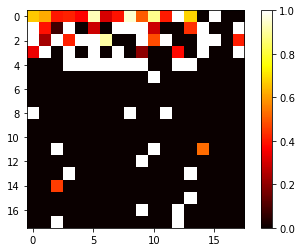

In [26]:
# nArray = np.array(X_scaled_df.iloc[0, :-1])
nArray = np.array(X_scaled_df.iloc[0, :], dtype='float32')


# a11=nArray.reshape(15,22)
nArray=nArray.reshape(18, 18)
plt.imshow(nArray, cmap='hot')
plt.colorbar()
plt.show()

In [27]:
'''export as csv'''

# append the label column
X_scaled_df['label'] = y_cat

X_scaled_df.to_csv('../data/home_sale_data_324.csv', index=False)

In [157]:
df = pd.read_csv('../data/home_sale_data_324.csv')
df

,OverallQual,GrLivArea,GarageCars,Total_Bathrooms,GarageArea,YrBltAndRemod,TotalBsmtSF,1stFlrSF,YearBuilt,FullBath,YearRemodAdd,TotalSF,Foundation_PConc,TotRmsAbvGrd,hasfireplace,ExterQual_Gd,Fireplaces,BsmtQual_Ex,HeatingQC_Ex,MasVnrArea,Total_porch_sf,BsmtFinType1_GLQ,KitchenQual_Ex,OpenPorchSF,GarageFinish_Fin,GarageType_Attchd,MSSubClass_60,KitchenQual_Gd,LotArea,ExterQual_Ex,Neighborhood_NridgHt,BsmtFinSF1,Exterior1st_VinylSd,WoodDeckSF,FireplaceQu_Gd,Exterior2nd_VinylSd,CentralAir_Y,LotFrontage,GarageCond_TA,Total_sqr_footage,PavedDrive_Y,GarageQual_TA,GarageYrBlt,SaleType_New,SaleCondition_Partial,BsmtQual_Gd,HalfBath,hasgarage,BsmtExposure_Gd,LotShape_IR1,Electrical_SBrkr,MSZoning_RL,MasVnrType_Stone,2ndFlrSF,BsmtFullBath,MasVnrType_BrkFace,Neighborhood_NoRidge,HouseStyle_2Story,RoofStyle_Hip,GarageFinish_RFn,GarageType_BuiltIn,hasbsmt,FireplaceQu_Ex,BsmtUnfSF,Neighborhood_StoneBr,FireplaceQu_TA,BedroomAbvGr,Neighborhood_Somerst,Fence_None,LandContour_HLS,LotConfig_CulDSac,BsmtCond_TA,BsmtExposure_Av,MSZoning_FV,Neighborhood_Timber,Functional_Typ,Neighborhood_CollgCr,Alley_None,BsmtFinType2_Unf,ExterCond_TA,Condition1_Norm,has2ndfloor,MSSubClass_120,LotShape_IR2,BldgType_1Fam,Heating_GasA,ScreenPorch,Exterior1st_CemntBd,BsmtCond_Gd,Exterior2nd_CmentBd,Neighborhood_Veenker,Neighborhood_Crawfor,RoofMatl_WdShngl,Condition1_PosN,Condition2_PosA,Neighborhood_Gilbert,MSSubClass_20,GarageQual_Gd,haspool,Condition2_PosN,MiscFeature_None,Neighborhood_NWAmes,Neighborhood_ClearCr,PoolArea,Condition1_PosA,RoofMatl_WdShake,BldgType_TwnhsE,Exterior2nd_ImStucc,BsmtExposure_Mn,3SsnPorch,LandSlope_Mod,LotShape_IR3,Neighborhood_SawyerW,YrSold_2007,ExterCond_Ex,Neighborhood_Blmngtn,BsmtFinType2_GLQ,Exterior1st_Stone,Exterior2nd_BrkFace,Exterior1st_BrkFace,LandContour_Low,HouseStyle_2.5Fin,Condition1_RRNn,LandSlope_Sev,MoSold_8,Alley_Pave,SaleType_Con,Condition1_RRAn,MoSold_7,SaleType_CWD,LotConfig_FR3,MoSold_9,MoSold_11,GarageCond_Gd,MoSold_1,BsmtFinType2_ALQ,MSSubClass_75,GarageQual_Ex,RoofStyle_Shed,MoSold_12,MoSold_6,RoofStyle_Flat,RoofMatl_Tar&Grv,YrSold_2009,MoSold_2,Fence_GdPrv,Foundation_Wood,HouseStyle_2.5Unf,LotConfig_Corner,LotConfig_FR2,YrSold_2006,MoSold_10,YrSold_2008,SaleType_ConLI,MSSubClass_80,Condition2_Norm,RoofStyle_Mansard,FireplaceQu_Fa,MiscFeature_Gar2,HouseStyle_SLvl,Exterior1st_Plywood,GarageType_2Types,Heating_OthW,BsmtFinSF2,Exterior2nd_Stone,GarageCond_Ex,MoSold_5,MoSold_3,MSSubClass_40,SaleCondition_Alloca,MiscFeature_Othr,Heating_GasW,Condition1_RRNe,Foundation_Stone,Exterior1st_CBlock,Functional_Maj1,Exterior2nd_AsphShn,BsmtFinType2_LwQ,BsmtHalfBath,Condition2_Feedr,BsmtFinType2_BLQ,SaleCondition_Family,Exterior2nd_CBlock,BsmtFinType2_Rec,Exterior1st_AsphShn,Condition2_Artery,Neighborhood_Mitchel,Exterior1st_BrkComm,Fence_MnWw,RoofStyle_Gambrel,Condition2_RRNn,Neighborhood_Blueste,Functional_Sev,Exterior2nd_Plywood,YrSold_2010,GarageType_Basment,SaleType_Oth,Neighborhood_NPkVill,MoSold_4,MSSubClass_85,LandSlope_Gtl,ExterCond_Po,MSSubClass_70,SaleType_ConLw,BsmtCond_Po,MasVnrType_BrkCmn,HouseStyle_1Story,ExterCond_Gd,LandContour_Lvl,Exterior2nd_Brk Cmn,MSZoning_RH,Condition1_RRAe,OverallCond,MiscVal,FireplaceQu_Po,Exterior1st_WdShing,LowQualFinSF,Functional_Min1,HeatingQC_Po,Functional_Mod,MiscFeature_Shed,GarageQual_Po,Exterior1st_Stucco,Exterior2nd_Stucco,BsmtFinType1_ALQ,RoofMatl_CompShg,Exterior2nd_Wd Shng,Functional_Min2,SaleType_ConLD,Heating_Wall,Neighborhood_SWISU,GarageType_CarPort,SaleCondition_AdjLand,MSSubClass_45,HouseStyle_SFoyer,Electrical_FuseP,Exterior2nd_HdBoard,LotConfig_Inside,HouseStyle_1.5Unf,MSSubClass_90,BldgType_Duplex,PavedDrive_P,BsmtFinType1_LwQ,MSSubClass_180,Functional_Maj2,Exterior1st_HdBoard,GarageCond_Po,SaleCondition_Normal,LandContour_Bnk,SaleType_COD,Fence_GdWo,Heating_Grav,MSSubClass_190,BldgType_2fmCon,KitchenAbvGr,BsmtFinType1_BLQ,BsmtFinType1_Unf,Neighborhood_BrDale,Condition1_Feedr,BldgType_Twnhs,MSSubClass_160,HeatingQC_Gd,Neighborhood_Sawyer,Condition1_Artery,Exterio

In [251]:
img.shape

(18, 18)

In [252]:
np.asarray(img)

array([[0.5568628 , 0.627451  , 0.4       , 0.2509804 , 0.32156864,
        0.7372549 , 0.27058825, 0.44705883, 0.81960785, 0.49803922,
        0.58431375, 0.35686275, 0.        , 0.6117647 , 1.        ,
        1.        , 0.29803923, 0.        ],
       [0.        , 0.49803922, 0.34509805, 0.        , 0.        ,
        0.24705882, 1.        , 1.        , 1.        , 1.        ,
        0.30588236, 0.        , 0.        , 0.        , 0.        ,
        0.2784314 , 0.        , 0.        ],
       [1.        , 0.28235295, 1.        , 0.31764707, 1.        ,
        1.        , 0.8980392 , 0.        , 0.        , 1.        ,
        0.47843137, 1.        , 0.        , 0.        , 1.        ,
        1.        , 0.        , 0.35686275],
       [0.        , 1.        , 0.        , 1.        , 0.        ,
        0.        , 0.        , 1.        , 0.        , 0.50980395,
        0.        , 1.        , 0.3764706 , 0.        , 1.        ,
        0.        , 0.        , 1.        ],
    

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


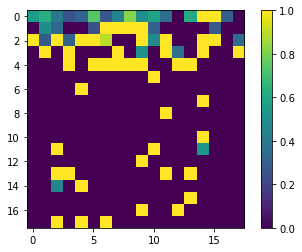

In [250]:
# nArray = np.reshape(nArray, (18, 18, 1))

# plt.imsave('test1.png', nArray, cmap='gray')



from PIL import Image

# Make PIL Image from Numpy array
# pImage = Image.fromarray(nArray)
# pImage.save('pil.jpeg')

import imageio
import numpy as np

# array = np.arange(0, 737280, 1, np.uint8)
# array = np.reshape(array, (1024, 720))

imageio.imwrite('test1.png', nArray)

img = plt.imread('test1.png')
plt.imshow(img)
plt.colorbar()
plt.show()

In [172]:
tmp_df = X_scaled_df.drop(['label'], axis=1)
tmp = tmp_df.iloc[0]
tmpnp = tmp.to_numpy()
tmpnp = np.reshape(tmpnp, (18, 18))
plt.imsave('test.png', tmpnp)

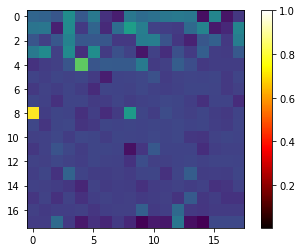

In [175]:
img = plt.imread('test.png')
plt.imshow(img, cmap='hot')
plt.colorbar()
plt.show()

In [ ]:
'''Try saving as an image'''
plt.imsave('test.jpeg', X[0])

In [17]:
# ################## ML ########################################
print('START ML', datetime.now(), )

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model, X=X):
    rmse = np.sqrt(-cross_val_score(model, X, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)


START ML 2022-04-16 17:22:20.008375


In [17]:
# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds,))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, random_state=42, l1_ratio=e_l1ratio))
                                        
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
                                   

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )
                                       

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006, random_state=42)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)


In [18]:
print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()), datetime.now(), )



TEST score on CV
Kernel Ridge score: 0.1024 (0.0143)
 2019-03-28 11:58:10.672219
Lasso score: 0.1031 (0.0147)
 2019-03-28 11:58:41.859226
ElasticNet score: 0.1031 (0.0149)
 2019-03-28 12:00:47.015025
SVR score: 0.1023 (0.0133)
 2019-03-28 12:01:00.265684
Lightgbm score: 0.1066 (0.0152)
 2019-03-28 12:01:15.386435
GradientBoosting score: 0.1071 (0.0135)
 2019-03-28 12:02:35.403817


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/x

Xgboost score: 0.1068 (0.0166)
 2019-03-28 12:04:42.824509


In [19]:
print('START Fit')
print(datetime.now(), 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X), np.array(y))
print(datetime.now(), 'elasticnet')
elastic_model_full_data = elasticnet.fit(X, y)
print(datetime.now(), 'lasso')
lasso_model_full_data = lasso.fit(X, y)
print(datetime.now(), 'ridge')
ridge_model_full_data = ridge.fit(X, y)
print(datetime.now(), 'svr')
svr_model_full_data = svr.fit(X, y)
print(datetime.now(), 'GradientBoosting')
gbr_model_full_data = gbr.fit(X, y)
print(datetime.now(), 'xgboost')
xgb_model_full_data = xgboost.fit(X, y)
print(datetime.now(), 'lightgbm')
lgb_model_full_data = lightgbm.fit(X, y)


START Fit
2019-03-28 12:04:42.853618 StackingCVRegressor
2019-03-28 12:08:50.651386 elasticnet
2019-03-28 12:09:04.206486 lasso
2019-03-28 12:09:07.180115 ridge
2019-03-28 12:09:11.816787 svr
2019-03-28 12:09:13.326422 GradientBoosting
2019-03-28 12:09:21.598692 xgboost


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


2019-03-28 12:09:35.938676 lightgbm


In [20]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.1 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.25 * stack_gen_model.predict(np.array(X))))
            
print('RMSLE score on train data:')
print(rmsle(y, blend_models_predict(X)))

print('Predict submission', datetime.now(),)
submission = pd.read_csv("../input/sample_submission.csv")
submission.iloc[:,1] = np.floor(np.expm1(blend_models_predict(X_sub)))

RMSLE score on train data:
0.05969732057511229
Predict submission 2019-03-28 12:09:39.262029


In [21]:
submission.to_csv("House_price_submission_v54.csv", index=False)
print('Save submission', datetime.now(),)

Save submission 2019-03-28 12:09:41.166176


In [22]:
submission.head()

,Id,SalePrice
0,1461,122993.0
1,1462,159175.0
2,1463,186547.0
3,1464,199729.0
4,1465,188552.0
